# Loan Acceptance Prediction

Read data and import libraries

In [43]:
import pandas as pd
import math as m
import numpy as np
path = "Dataset/Loan/train.csv"
data = pd.read_csv(path)

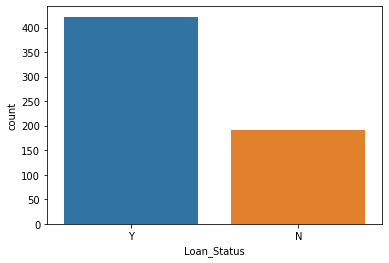

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.countplot(data['Loan_Status'])
plt.show()

Data preprocessing

In [74]:
from sklearn.preprocessing import StandardScaler
def preprocess(data,training=True,data_size=None,n_data=10):
    #remove NaN values
    data = data.fillna(0)
    #separate numerical and categorical data from each other
    numerical = data[["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]]
    categorical = data[["Dependents","Education","Property_Area","Credit_History"]]
    #convert categorical to dummy variables
    dum_cate = pd.get_dummies(categorical)
    #combine numerical and cateforical data
    

    if training:
        data = pd.concat([dum_cate,numerical,data['Loan_Status']],axis=1).sample(frac=1)
#         Yes_data = data.loc[data['Loan_Status']=='Y']
#         No_data = data.loc[data['Loan_Status']=='N']
#         this_data = pd.concat([Yes_data,No_data],axis=0)
        this_X = data.iloc[:,:-1]
        this_y = data['Loan_Status']

        ss = StandardScaler()
        X_data = pd.DataFrame(data=ss.fit_transform(this_X),columns=this_X.columns,index=data.index)
        y_data = np.array([int(ele=='Y') for ele in this_y])
    else:
        data = pd.concat([dum_cate,numerical],axis=1)
        #standardize data
        ss = StandardScaler()
        X_data = pd.DataFrame(data=ss.fit_transform(data),columns=data.columns)
        y_data = []
    return X_data,y_data,

In [120]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report
# def get_wrong_data(X_data,y_data,model):
#     kf = KFold(n_splits=10,shuffle=True)
#     splits = kf.split(X_data)
#     wrong_data = set()
#     for train_i,val_i in splits:
#         X_train = np.take(X_data,train_i,axis=0)
#         y_train = np.take(y_data,train_i,axis=0)
#         X_val = np.take(X_data,val_i,axis=0)
#         y_val = np.take(y_data,val_i,axis=0)
#         model.fit(X_train,y_train)
#         prediction = model.predict(X_val)
#         for p,t,i in zip(list(prediction),list(y_val),val_i):
#             if p != t:
#                 wrong_data.add(i)
#     wrong_X = np.take(X_data,list(wrong_data),axis=0)
#     wrong_y = np.take(y_data,list(wrong_data),axis=0)
#     return wrong_X,wrong_y,list(wrong_data)

def get_wrong_data(X_train,y_train,X_test,y_test,model):
    wrong_data = set()
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    for p,t,i in zip(list(prediction),list(y_test),X_test.index):
        if p != t:
            wrong_data.add(i)
    wrong_X = np.take(X_test,list(wrong_data),axis=0)
    wrong_y = np.take(y_test,list(wrong_data),axis=0)
    return wrong_X,wrong_y,list(wrong_data)

In [132]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
model = SVC(kernel = 'linear')
X_data,y_data = preprocess(data)
wrong_X,wrong_y,index = get_wrong_data(X_data,y_data,X_data,y_data,model)

print(classification_report(y_data,model.predict(X_data)))

              precision    recall  f1-score   support

           0       0.68      0.49      0.57       192
           1       0.80      0.90      0.84       422

    accuracy                           0.77       614
   macro avg       0.74      0.70      0.71       614
weighted avg       0.76      0.77      0.76       614



In [131]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_data,y_data)
print(classification_report(y_data,model.predict(X_data)))

              precision    recall  f1-score   support

           0       0.74      0.51      0.60       192
           1       0.80      0.92      0.86       422

    accuracy                           0.79       614
   macro avg       0.77      0.71      0.73       614
weighted avg       0.79      0.79      0.78       614



In [135]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
model.fit(X_data,y_data)
print(classification_report(y_data,model.predict(X_data)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       192
           1       0.98      0.99      0.98       422

    accuracy                           0.98       614
   macro avg       0.98      0.97      0.98       614
weighted avg       0.98      0.98      0.98       614



In [122]:
wrong = data.iloc[wrong_X.index,:]
right = data.drop(wrong_X.index,axis=0)

In [163]:
#import machine learning libraries
from sklearn.model_selection import GridSearchCV


#Define the search parameters in lists
n_estimators = [60]
max_depth = [3]
min_samples_split = [4]
min_samples_leaf = [3]
class_weight = ['balanced']
max_features = [None]
#Make a dictionary of search parameters
param_grid = dict(n_estimators=n_estimators,max_depth=max_depth,
                  min_samples_split=min_samples_split,
                 min_samples_leaf=min_samples_leaf,
                 class_weight=class_weight,
                 max_features=max_features)
#Build and fit the RandomizedSearchCV. I have used GridSeachCV before but since the algorithm is 
#going through every permutation possible, it is very expansive computationally. RandomizedSearchCV
#only go through the permutation randomly, it gives an estimate of what the best parameters should be.

#KFold is a cross validation method to estimate the accuracy of the model without using the test set.
#Here I am setting the random_state to a seed so that it will split the same way every training. 
search = GridSearchCV(estimator=model, param_grid=param_grid,cv=10,scoring='f1',verbose=0)
_=search.fit(X_data,y_data)

C:\Users\Chris\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [164]:
print(classification_report(y_data,search.predict(X_data)))
print(search.best_params_)
print(search.best_score_)

              precision    recall  f1-score   support

           0       0.70      0.51      0.59       192
           1       0.80      0.90      0.85       422

    accuracy                           0.78       614
   macro avg       0.75      0.70      0.72       614
weighted avg       0.77      0.78      0.77       614

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 60}
0.8442544779181953


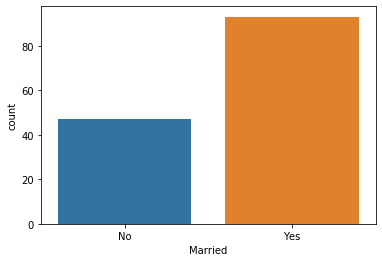

In [123]:
sns.countplot(wrong.iloc[:,2])

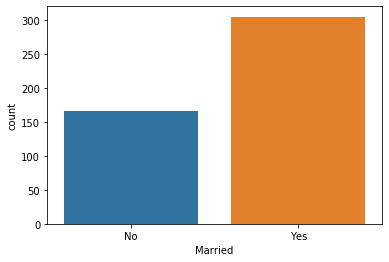

In [124]:
sns.countplot(right.iloc[:,2])

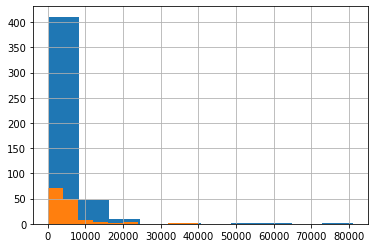

In [117]:
right.iloc[:,6].hist()
wrong.iloc[:,6].hist()
plt.show()

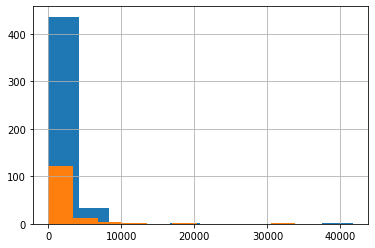

In [119]:
right.iloc[:,7].hist()
wrong.iloc[:,7].hist()
plt.show()

In [10]:
a = [5,4,3,2,1]
np.take(a,[0,2,3],axis=0)

array([5, 3, 2])

In [6]:
import numpy as np
class Voting:
    def __init__(self,names_models):
        self.names_models = names_models
    def predict(self,X):
        preds = []
        for name,model in self.names_models:
            preds.append(model.predict(X))
        preds = np.array(preds)
#         print(preds)
        preds = np.mean(preds,axis=0)
#         print(preds.shape)
#         print(preds)
        return np.round(preds)


In [7]:
X_list,y_list = preprocess(data,training=True,data_size=30,n_data=300)

from sklearn.svm import SVR
names = []
models = []
i = 0
for X,y in zip(X_list,y_list):
    linear = SVR(kernel='sigmoid',gamma='auto')
    linear.fit(X,y)
    names.append(str(i))
    models.append(linear)
    i+=1

model = Voting(list(zip(names,models)))

In [ ]:
from sklearn.metrics import f1_score
train_X,train = preprocess(data,training=False)
f1_score(model)

In [ ]:
# from sklearn.metrics import accuracy_score
# def select(X_list,y_list,models):
    
#     acc = []
#     for i,(X,y,model) in enumerate(zip(X_list,y_list,models)):
#         X_val = pd.DataFrame([[]],columns=X.columns)
#         y_val = pd.DataFrame(columns=y.columns)
#         for j,(df_X,df_y) in enumerate(zip(X_list,y_list)):
#             if j != i:
#                 X_val = pd.concat([X_val,df_X],axis=0)
#                 y_val = pd.concat([y_val,df_y],axis=0)
#         acc.append(accuracy_score(y_val,model.predict(X_val)))
        

In [8]:
test_path = "Dataset/Loan/test.csv"
test_data = pd.read_csv(test_path)

test_X,_ = preprocess(test_data,training=False)

test_data['Loan_Status'] = model.predict(test_X)

test_data['Loan_Status'] = ['Y' if e==1 else 'N' for e in test_data['Loan_Status']]

test_data[['Loan_ID','Loan_Status']].to_csv('Dataset/Loan/submit2.csv',index=False)

In [9]:
test_data[['Loan_ID','Loan_Status']].to_csv('Dataset/Loan/submit2.csv',index=False)